In [15]:
import joblib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from pytorch3d.transforms import matrix_to_axis_angle

import ipywidgets as widgets
from IPython.display import display

from pycocotools import mask as mask_utils

In [2]:
path_to_results = "/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/phalp_v2/results/demo_images.pkl"
phalp_res = joblib.load(path_to_results)

In [3]:
# Get all trakced_ids
tracked_ids = []
for v in phalp_res.values():
    tracked_ids.extend(v['tracked_ids'])
tracked_ids = list(set(tracked_ids))
tracked_ids

[1, 2, 5]

In [4]:
for k in phalp_res.keys():
    print(k)

/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00000.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00001.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00002.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00003.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00004.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00005.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00006.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00007.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00008.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00009.jpg
/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00010.jpg
/scratch/izar/cizinsk

In [5]:
extract_id = lambda name: int(name.split("_")[1].split(".")[0])

In [6]:
keys = list(phalp_res.keys())
path = Path(keys[0])
extract_id(path.name)

0

In [7]:
values = list(phalp_res.values())
value = values[-1]
value

{'time': 86,
 'shot': 0,
 'frame_path': '/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/images/frame_00086.jpg',
 'tracked_ids': [1, 2, 5],
 'tracked_bbox': [array([560.5912  ,  51.498013, 304.42212 , 598.1648  ], dtype=float32),
  array([1101.1768 ,  102.24281,  178.73547,  416.5526 ], dtype=float32),
  array([  1.3556576, 178.2539   , 232.4225   , 459.16656  ], dtype=float32)],
 'tid': [1, 2, 5],
 'bbox': [array([560.5912  ,  51.498013, 304.42212 , 598.1648  ], dtype=float32),
  array([1101.1768 ,  102.24281,  178.73547,  416.5526 ], dtype=float32),
  array([  1.3556576, 178.2539   , 232.4225   , 459.16656  ], dtype=float32)],
 'tracked_time': [0, 0, 0],
 'appe': [array([ 6.9077263,  8.65995  ,  9.134255 , ...,  9.289854 , 11.6039505,
          7.90132  ], shape=(4096,), dtype=float32),
  array([ 5.657496,  7.907972,  9.922656, ..., 10.112618, 11.332506,
          6.805666], shape=(4096,), dtype=float32),
  array([ 6.290752 ,  6.295789 ,  6.2599373, ..., 11.698735 

In [8]:
i = value["tid"].index(2)
print(f"i: {i}")
img_size = max([value['size'][i][1], value['size'][i][0]])
print(f"img_size: {img_size}")
j2d = v['2d_joints'][i].reshape(-1, 2)
print(f"j2d: {j2d.shape}, before reshape the shape is {v['2d_joints'][i].shape}, min max range of j2d is {j2d.min()} {j2d.max()}")
v_size = v['size'][i]
print(f"v_size: {v_size}")

i: 1
img_size: 1280
j2d: (45, 2), before reshape the shape is (90,), min max range of j2d is 0.31622740626335144 1.0509358644485474
v_size: [720, 1280]


<img src="https://user-images.githubusercontent.com/29478970/76984773-94e34580-693f-11ea-9bcd-7af6fbb1d521.png" width="50%">


In [9]:
def phalp_smpl2op(smpl_joints):
    j_inds = np.arange(25)
    j_inds[19] = 22
    j_inds[20] = 23
    j_inds[21] = 24
    j_inds[22] = 19
    j_inds[23] = 20
    j_inds[24] = 21


    op_joints = []
    for j_ind in j_inds:
        if j_ind >= len(smpl_joints):
            print("Warning: this should not happen...")
            op_joints.append(None)
        else:
            op_joints.append(smpl_joints[j_ind])

    return op_joints

In [10]:

# --- prep: order frames consistently (e.g., by filename) ---
keys = sorted(phalp_res.keys())
frames = [phalp_res[k] for k in keys]

# all PIDs observed across the sequence
all_pids = sorted({pid for v in frames for pid in v['tracked_ids']})

# --- widget controls ---
frame_slider = widgets.IntSlider(
    value=0, min=0, max=len(frames)-1, step=1,
    description='Frame', continuous_update=False
)
pid_dropdown = widgets.Dropdown(
    options=all_pids, value=all_pids[0], description='PID'
)

def show_frame(frame_idx:int, pid:int):
    value = frames[frame_idx]
    frame_path = value['frame_path']
    img = cv2.imread(frame_path)
    if img is None:
        print(f"Could not read image at {frame_path}")
        return

    # Convert BGR -> RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if pid not in value['tid']:
        # PID not present in this frame -> just show image with a note
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb); plt.axis("off")
        plt.title(f"PID {pid} not present in frame {frame_idx}")
        plt.show()
        return

    i = value['tid'].index(pid)
    h, w = value['size'][i]                 # size = [H, W]
    joints = value['2d_joints'][i]          # flat length-90 array
    j2d = joints.reshape(-1, 2)             # (45, 2)

    # map from normalized square-crop coords -> image pixel coords
    img_size = max(h, w)
    j2d = j2d * img_size
    j2d = j2d + np.array([[w - img_size, h - img_size]]) / 2.0

    # keep OpenPose-style 25 joints then remap to OP order
    j2d = j2d[:25]
    j2d = phalp_smpl2op(j2d)                # assumes you have this

    # plot
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    xs = [p[0] for p in j2d if p is not None]
    ys = [p[1] for p in j2d if p is not None]
    plt.scatter(xs, ys, s=40)               # no color specified; uses default
    plt.axis("off")
    plt.title(f"Frame {frame_idx} | PID {pid}")
    plt.show()

out = widgets.interactive_output(show_frame, {'frame_idx': frame_slider, 'pid': pid_dropdown})
display(widgets.HBox([frame_slider, pid_dropdown]), out)

Output()

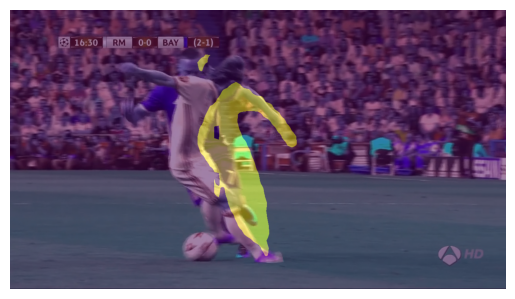

In [11]:
values = list(phalp_res.values())
value = values[38]
i = value['tid'].index(1)

mask = mask_utils.decode(value['mask'][i][0])
frame_path = value['frame_path']
img = cv2.imread(frame_path)

plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.axis('off')

plt.show()

In [12]:
values = list(phalp_res.values())
value = values[38]
i = value['tid'].index(1)

smpl_estimation = value['smpl'][i]

print(f"available keys: {list(smpl_estimation.keys())}")

available keys: ['global_orient', 'body_pose', 'betas']


In [13]:
smpl_estimation["global_orient"].shape, smpl_estimation["body_pose"].shape, smpl_estimation["betas"].shape

((1, 3, 3), (23, 3, 3), (10,))

In [14]:
smpl_estimation["global_orient"]

array([[[ 0.9509541 , -0.26877615,  0.15311971],
        [-0.28966686, -0.94742507,  0.13593727],
        [ 0.10853275, -0.17362383, -0.9788133 ]]], dtype=float32)

In [17]:
def rotation_matrix_to_axis_angle(R):
    trace = R[:,0,0] + R[:,1,1] + R[:,2,2]
    angle = np.arccos((trace - 1) / 2.0)

    
    axis = np.array([R[:, 2, 1] - R[:, 1, 2], R[:, 0, 2] - R[:, 2, 0], R[:, 1, 0] - R[:, 0, 1]])
    axis = axis.T
    axis /= np.sqrt((axis ** 2).sum(-1, keepdims=True))
    
    axis[angle < 1e-6] = axis[angle < 1e-6]*0 + np.array([1.0, 0.0, 0.0])[None]
    
    # Finally convert in SMPL format
    # Where, norm is angle, axis is just direction
    axis = axis * angle[..., None]
    
    return axis

def rotmat_to_axisangle(R: torch.Tensor) -> torch.Tensor:
    """
    Convert rotation matrices to axis-angle (Rodrigues) vectors.
    Args:
        R: (..., 3, 3) tensor of rotation matrices (e.g., (N,3,3)).
    Returns:
        rotvec: (..., 3) tensor of axis-angle vectors.
    """
    if R.shape[-2:] != (3, 3):
        raise ValueError(f"Expected (...,3,3) rotation matrices, got {R.shape}")
    return matrix_to_axis_angle(R)


In [ ]:
r1 = torch.tensor(rotation_matrix_to_axis_angle(smpl_estimation["body_pose"]))
r2 = rotmat_to_axisangle(torch.tensor(smpl_estimation["body_pose"])) #torch3d implementation
torch.allclose(r1, r2)

True

In [ ]:
# global_orient = rotation_matrix_to_axis_angle(smpl_estimation['global_orient']).reshape(-1)
# body_pose = rotation_matrix_to_axis_angle(smpl_estimation['body_pose']).reshape(-1)
# beta = smpl_estimation['betas']
# transl = v['camera'][i]                         # PHALP assumed F=5000 here. We need to align it in future